<a href="https://colab.research.google.com/github/Hanhpt23/Multi-Class-Segmentation-SegFormer/blob/main/Fine_tune_SegFormer_on_ADE20K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes:
This file is sourced from [Finetune SegFormer](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb). During the learning process, I encountered challenges in defining the model. As a result, I created this version, which proved effective for my needs.


# Modifications from the original file
1. Upload the 'ade20k-id2label.json' file
2. Dataloader
3. Data inference

In this notebook, we are going to fine-tune `SegFormerForSemanticSegmentation` on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00


## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [2]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [3]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the feature extractor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [4]:
from transformers import SegformerFeatureExtractor

root_dir = 'ADE20k_toy_dataset'
feature_extractor = SegformerFeatureExtractor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, train=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:100: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [6]:
encoded_inputs = train_dataset[0]

In [7]:
print(encoded_inputs)

{'pixel_values': tensor([[[ 0.9817,  0.9817,  0.9817,  ...,  0.8447,  0.8447,  0.8447],
         [ 0.9817,  0.9817,  0.9817,  ...,  0.8447,  0.8276,  0.8276],
         [ 0.9817,  0.9817,  0.9817,  ...,  0.8447,  0.8276,  0.8276],
         ...,
         [-0.7993, -0.7822, -0.7822,  ..., -1.4158, -1.3987, -1.3987],
         [-0.7479, -0.7650, -0.8335,  ..., -1.4329, -1.4500, -1.4500],
         [-0.7479, -0.7993, -0.9020,  ..., -1.4672, -1.4329, -1.4329]],

        [[ 1.2381,  1.2381,  1.2381,  ...,  1.0980,  1.0980,  1.0980],
         [ 1.2381,  1.2381,  1.2381,  ...,  1.0980,  1.0805,  1.0805],
         [ 1.2381,  1.2381,  1.2381,  ...,  1.0980,  1.0805,  1.0805],
         ...,
         [-0.6176, -0.6001, -0.6001,  ..., -1.1954, -1.1779, -1.1779],
         [-0.5651, -0.5826, -0.6527,  ..., -1.2129, -1.2304, -1.2304],
         [-0.5651, -0.6176, -0.7402,  ..., -1.2479, -1.2129, -1.2129]],

        [[ 1.4548,  1.4548,  1.4548,  ...,  1.3154,  1.3154,  1.3154],
         [ 1.4548,  1.4548, 

In [8]:
encoded_inputs["pixel_values"].shape, encoded_inputs["labels"].shape


(torch.Size([3, 512, 512]), torch.Size([512, 512]))

In [9]:
print(encoded_inputs["pixel_values"].max(), encoded_inputs["pixel_values"].min())
print(encoded_inputs["labels"].max(), encoded_inputs['labels'].min())

tensor(2.6400) tensor(-2.0494)
tensor(255) tensor(0)


In [10]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [11]:
print(encoded_inputs["labels"].max(), encoded_inputs["labels"].min())

tensor(255) tensor(0)


In [12]:
print(encoded_inputs["labels"].shape, encoded_inputs["labels"].squeeze().unique().shape)

torch.Size([512, 512]) torch.Size([17])


In [13]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [15]:
batch = next(iter(train_dataloader))

In [16]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [17]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [18]:
batch["labels"]

tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255,   0,   0,  ...,   5, 255, 255],
         [255,   0,   0,  ...,   5, 255, 255],
         ...,
         [255,   3,   3,  ...,   3,   3, 255],
         [255,   3,   3,  ...,   3,   3, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]])

In [19]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False,  True,  True,  ...,  True, False, False],
         [False,  True,  True,  ...,  True, False, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [20]:
batch["labels"][mask]

tensor([ 0,  0,  0,  ..., 12, 12, 12])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

Download the link below and put it into the current working path
[ade20k-id2label.json](https://drive.google.com/file/d/182dSkkEM2E3Ob9_9a0MBblWz7I4JsJbU/view?usp=drive_link)

In [22]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

# load id2label mapping from a JSON on the hub
repo_id = "datasets/huggingface/label-files"
filename = "ade20k-id2label.json"

with open(filename, 'r') as j:
    id2label = json.loads(j.read())

id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_var']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
print(len(id2label))

150


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [24]:
from datasets import load_metric

metric = load_metric("mean_iou")

<ipython-input-24-7fa4e6e26caa>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("mean_iou")


In [ ]:
# # Check the model if you want
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3",
#                                                          num_labels=150,
#                                                          id2label=id2label,
#                                                          label2id=label2id,
# )
# print(model)
# total = sum([param.nelement() for param in model.parameters()])
# print("Number of parameter: %.2fM" % (total / 1e6))

In [27]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from datasets import load_metric
metric = load_metric("mean_iou")

# '''--------------------------------------------------------------'''
# Fine tuning the model

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(100):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        # print(outputs)
        # loss.requires_grad = True

        # loss.retain_grad()
        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          metrics = metric._compute(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy(),
                                    num_labels=len(id2label),
                                   ignore_index=255,
                                   reduce_labels=False, # we've already reduced the labels before)
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])


Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.081943035125732
Mean_iou: 0.00022810400381401434
Mean accuracy: 0.0017852529341424155
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.646366596221924
Mean_iou: 0.0052496098018496055
Mean accuracy: 0.08078111104083545
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.9896938800811768
Mean_iou: 0.02162282031476701
Mean accuracy: 0.312003252505963
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.5231120586395264
Mean_iou: 0.03470834542464547
Mean accuracy: 0.19697634781050927
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.87964129447937
Mean_iou: 0.0980213288321808
Mean accuracy: 0.3762509085318866
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8612533807754517
Mean_iou: 0.3816269540154496
Mean accuracy: 0.6023066258067724
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6004282236099243
Mean_iou: 0.2627076615267932
Mean accuracy: 0.33099867671548155
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8334465026855469
Mean_iou: 0.2160408979971671
Mean accuracy: 0.33140046640776905
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4615978002548218
Mean_iou: 0.3262381998555618
Mean accuracy: 0.46157180531715497
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.260745644569397
Mean_iou: 0.3067533685509567
Mean accuracy: 0.47592542273522753
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2616276741027832
Mean_iou: 0.2507840984815574
Mean accuracy: 0.38064795809005536
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8559606671333313
Mean_iou: 0.34564588243906874
Mean accuracy: 0.46044569314331557
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1685997247695923
Mean_iou: 0.35066332210595996
Mean accuracy: 0.6142795422456347
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6049304604530334
Mean_iou: 0.3593725365136872
Mean accuracy: 0.47752518381479886
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8729771971702576
Mean_iou: 0.679465962025954
Mean accuracy: 0.8257849209818557
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5998280644416809
Mean_iou: 0.5087933080811929
Mean accuracy: 0.5919918524816692
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8262458443641663
Mean_iou: 0.4544225669207951
Mean accuracy: 0.6373207011673181
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5877874493598938
Mean_iou: 0.32986239585902916
Mean accuracy: 0.3867951891742129
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3423667550086975
Mean_iou: 0.46368112287938934
Mean accuracy: 0.5619945371046166
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7772715091705322
Mean_iou: 0.20825315702620747
Mean accuracy: 0.3161695837964519
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3986779749393463
Mean_iou: 0.5120464667288573
Mean accuracy: 0.5597840094031379
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5775888562202454
Mean_iou: 0.425031725891743
Mean accuracy: 0.6018122044485815
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4277140200138092
Mean_iou: 0.6076603187665458
Mean accuracy: 0.6857440271241513
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24960966408252716
Mean_iou: 0.48808227233650026
Mean accuracy: 0.695043474607428
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28975966572761536
Mean_iou: 0.6093428880166598
Mean accuracy: 0.6793759064769407
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39317426085472107
Mean_iou: 0.5909705992478212
Mean accuracy: 0.660802245443341
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2377554327249527
Mean_iou: 0.7062957262064774
Mean accuracy: 0.8315239008093467
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Inference

Finally, let's check whether the model has really learned something. Let's test the trained model on an image:

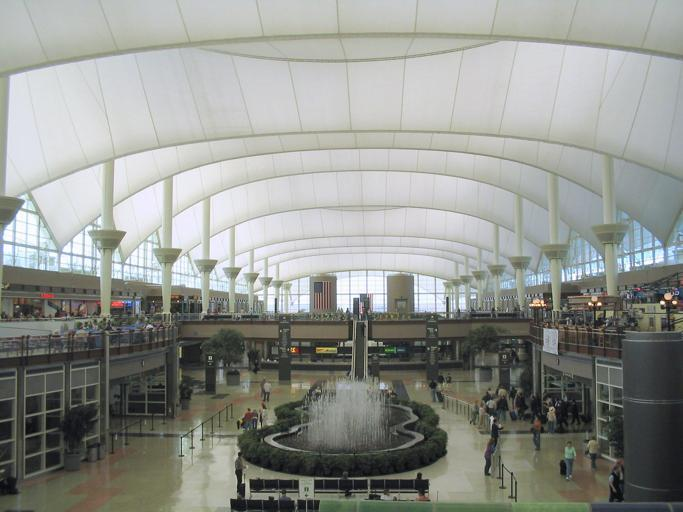

In [28]:
image = Image.open('ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [29]:
# prepare the image for the model
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [30]:
# forward pass
outputs = model(pixel_values=pixel_values)

In [31]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [32]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

torch.Size([512, 683]) torch.Size([1, 150, 512, 683])
(512, 683, 3)


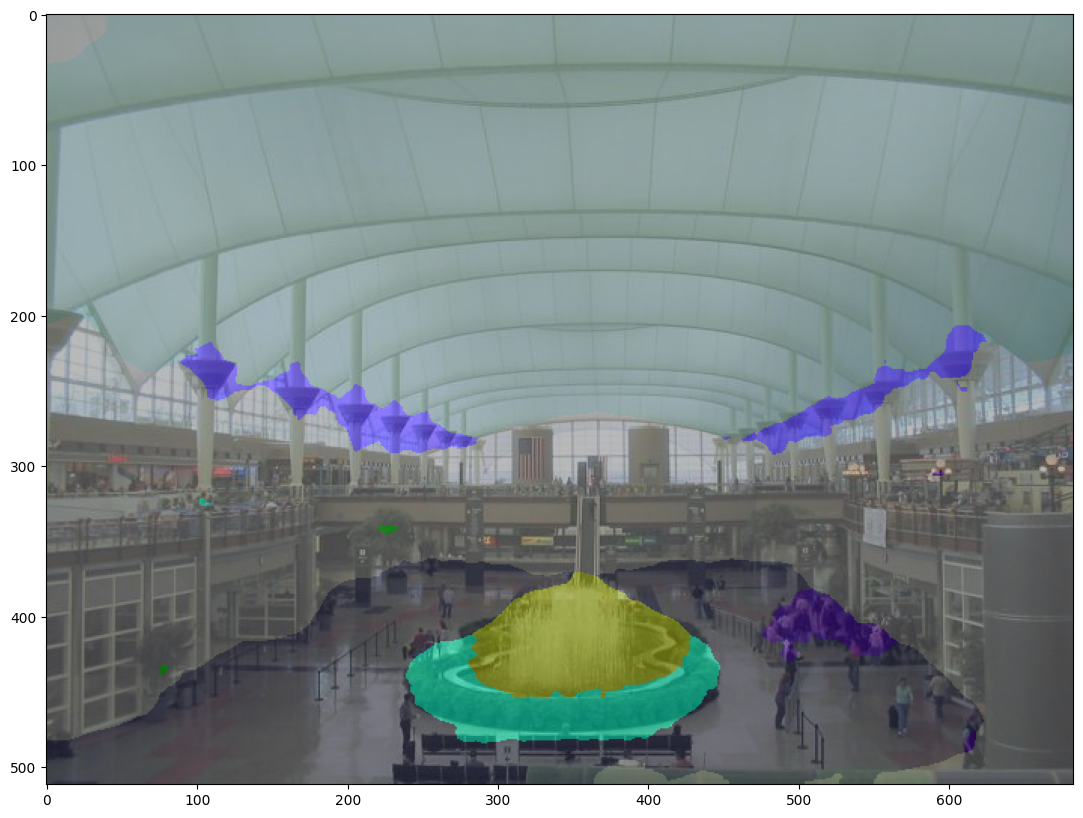

tensor(104) tensor(0)


In [33]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)
print(upsampled_logits.argmax(dim=1)[0].shape, upsampled_logits.shape)
# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
print(img.shape)
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()
print(seg.max(), seg.min())

Compare this to the ground truth segmentation map:

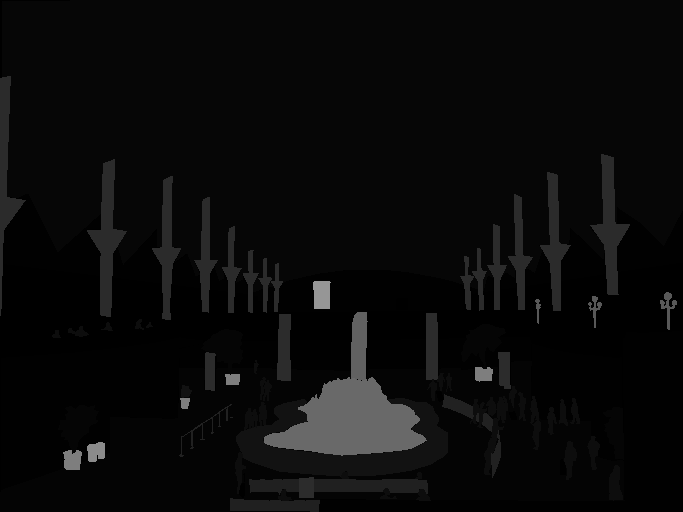

In [34]:
map = Image.open('ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png')
map

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


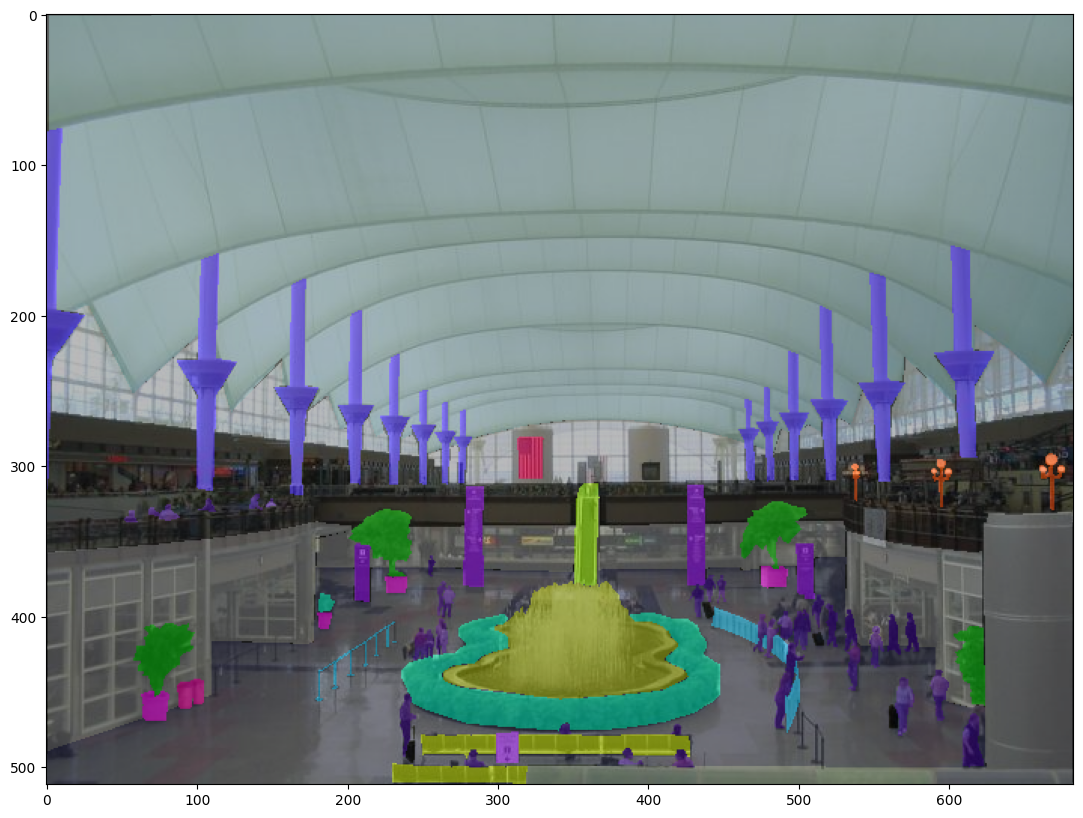

In [35]:
# convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [36]:
seg.unique()

tensor([  0,   3,   4,   5,  12,  17,  27,  42, 104])

In [37]:
model.config.id2label[37]

'bathtub'

In [38]:
np.unique(map)

array([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104,
       125, 138, 149, 255], dtype=uint8)

In [39]:
seg

tensor([[0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        ...,
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0]])

In [40]:
map

array([[255, 255, 255, ...,   5,   5,   5],
       [255, 255,   5, ...,   5,   5,   5],
       [255, 255,   5, ...,   5,   5,   5],
       ...,
       [  3,   3,   3, ...,   0,   0, 255],
       [  3,   3,   3, ...,   0,   0, 255],
       [  3,   3,   3, ...,   0,   0,   0]], dtype=uint8)

Let's compute the metrics:

In [41]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(predictions=[seg.numpy()], references=[map], num_labels=150, ignore_index=255)

In [42]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [43]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.24331438857025334
mean_accuracy 0.31251148188752054
overall_accuracy 0.8659684269623719
---------------------
per-category metrics:


,IoU,accuracy
wall,0.722167,0.916048
building,NaN,NaN
sky,NaN,NaN
floor,0.700229,0.908841
tree,0.021610,0.021610
...,...,...
shower,NaN,NaN
radiator,NaN,NaN
glass,NaN,NaN
clock,NaN,NaN
